In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error, mean_absolute_error
from sklearn.model_selection import RandomizedSearchCV
import sys
import seaborn as sns

In [ ]:
def preprocess_data(df):
    # Add datetime parameters for saledate
    df["saleYear"] = df.saledate.dt.year
    df["saleMonth"] = df.saledate.dt.month
    df["saleDay"] = df.saledate.dt.day
    df["saleDayofweek"] = df.saledate.dt.dayofweek
    df["saleDayofyear"] = df.saledate.dt.dayofyear

    # Drop original saledate
    df.drop("saledate", axis=1, inplace=True)
    
    # Fill numeric rows with the median
    for label, content in df.items():
        if pd.api.types.is_numeric_dtype(content):
            if pd.isnull(content).sum():
                df[label+"_is_missing"] = pd.isnull(content)
                df[label] = content.fillna(content.median())
                
        # Turn categorical variables into numbers
        if not pd.api.types.is_numeric_dtype(content):
            df[label+"_is_missing"] = pd.isnull(content)
            # We add the +1 because pandas encodes missing categories as -1
            df[label] = pd.Categorical(content).codes+1        
    
    return df

In [ ]:
def plot_features(columns, importances, n=20):
    df = (pd.DataFrame({"features": columns,
                        "feature_importance": importances})
          .sort_values("feature_importance", ascending=False)
          .reset_index(drop=True))
    
    sns.barplot(x="feature_importance",
                y="features",
                data=df[:n],
                orient="h")

In [ ]:
def rmsle(y_test, y_preds):
    return np.sqrt(mean_squared_log_error(y_test, y_preds))

In [ ]:
# Create function to evaluate our model
def show_scores(model):
    train_preds = model.predict(X_train)
    val_preds = model.predict(X_valid)
    scores = {"Training MAE": mean_absolute_error(y_train, train_preds),
              "Valid MAE": mean_absolute_error(y_valid, val_preds),
              "Training RMSLE": rmsle(y_train, train_preds),
              "Valid RMSLE": rmsle(y_valid, val_preds),
              "Training R^2": model.score(X_train, y_train),
              "Valid R^2": model.score(X_valid, y_valid)}
    return scores

In [ ]:
df = pd.read_csv("/content/TrainAndValid.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (13,39,40,41) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


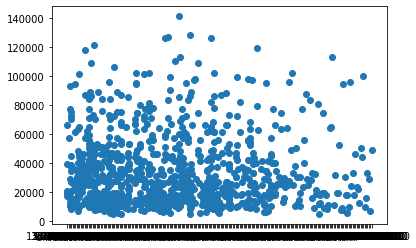

In [ ]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000],df["SalePrice"][:1000])

In [ ]:
df = pd.read_csv("/content/TrainAndValid.csv",
                 low_memory = False,
                 parse_dates = ["saledate"])

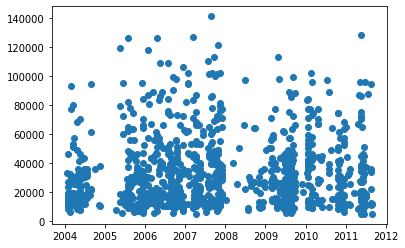

In [ ]:
fig, ax = plt.subplots()
ax.scatter(df["saledate"][:1000], df["SalePrice"][:1000])

In [ ]:
df.sort_values(by=["saledate"],inplace = True,ascending = True)
df.saledate.head(20)

205615   1989-01-17
274835   1989-01-31
141296   1989-01-31
212552   1989-01-31
62755    1989-01-31
54653    1989-01-31
81383    1989-01-31
204924   1989-01-31
135376   1989-01-31
113390   1989-01-31
113394   1989-01-31
116419   1989-01-31
32138    1989-01-31
127610   1989-01-31
76171    1989-01-31
127000   1989-01-31
128130   1989-01-31
127626   1989-01-31
55455    1989-01-31
55454    1989-01-31
Name: saledate, dtype: datetime64[ns]

In [ ]:
df_tmp = df.copy()

In [ ]:
for label, content in df_tmp.items():
  if pd.api.types.is_string_dtype(content):
    df_tmp[label] = content.astype("category").cat.as_ordered()

In [ ]:
preprocess_data(df_tmp)

,SalesID,SalePrice,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,...,Undercarriage_Pad_Width_is_missing,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing
205615,1646770,9500.0,1126363,8434,132,18.0,1974,0.0,0,4593,...,True,True,True,True,True,False,False,False,True,True
274835,1821514,14000.0,1194089,10150,132,99.0,1980,0.0,0,1820,...,True,True,True,True,True,True,True,True,False,False
141296,1505138,50000.0,1473654,4139,132,99.0,1978,0.0,0,2348,...,True,True,True,True,True,False,False,False,True,True
212552,1671174,16000.0,1327630,8591,132,99.0,1980,0.0,0,1819,...,True,True,True,True,True,True,True,True,False,False
62755,1329056,22000.0,1336053,4089,132,99.0,1984,0.0,0,2119,...,True,True,True,True,True,False,False,False,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
410879,6302984,16000.0,1915521,5266,149,99.0,2001,0.0,0,2101,...,True,True,True,True,True,False,False,False,True,True
412476,6324811,6000.0,1919104,19330,149,99.0,2004,0.0,0,240,...,True,True,True,True,True,True,True,True,True,True
411927,6313029,16000.0,1918416,17244,149,99.0,2004,0.0,0,627,...,True,True,True,True,True,True,True,True,True,True
407124,6266251,55000.0,509560,3357,149,99.0,1993,0.0,0,83,...,True,True,True,True,True,True,True,True,True,True


In [ ]:
# Instantiate model
model = RandomForestRegressor(n_jobs=-1)

# Fit the model
model.fit(df_tmp.drop("SalePrice", axis=1)[:10000], df_tmp.SalePrice[:10000])

RandomForestRegressor(n_jobs=-1)

In [ ]:
df_val = df_tmp[df_tmp.saleYear == 2012]
df_train = df_tmp[df_tmp.saleYear != 2012]

len(df_val), len(df_train)

(11573, 401125)

In [ ]:
X_train, y_train = df_train.drop("SalePrice", axis=1), df_train.SalePrice
X_valid, y_valid = df_val.drop("SalePrice", axis=1), df_val.SalePrice

X_train.shape, y_train.shape, X_valid.shape, y_valid.shape

((401125, 102), (401125,), (11573, 102), (11573,))

In [ ]:
model.fit(X_train[:10000], y_train[:10000])
show_scores(model)

{'Training MAE': 24280.3413624182,
 'Valid MAE': 27322.08089518707,
 'Training RMSLE': 0.854593154808389,
 'Valid RMSLE': 0.8906436822263614,
 'Training R^2': -0.8691981087208167,
 'Valid R^2': -0.7112289402264127}

In [ ]:
# Different RandomForestClassifier hyperparameters
rf_grid = {"n_estimators": np.arange(10, 100, 10),
           "max_depth": [None, 3, 5, 10],
           "min_samples_split": np.arange(2, 20, 2),
           "min_samples_leaf": np.arange(1, 20, 2),
           "max_features": [0.5, 1, "sqrt", "auto"],
           "max_samples": [10000]}

rs_model = RandomizedSearchCV(RandomForestRegressor(),
                              param_distributions=rf_grid,
                              n_iter=20,
                              cv=5,
                              verbose=True)

rs_model.fit(X_train[:10000], y_train[:10000])

Fitting 5 folds for each of 20 candidates, totalling 100 fits


/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
100 fits failed out of a total of 100.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
100 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 386, in fit
    n_samples=X.shape[0], max_samples=self.max_samples
  File "/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py", line 111, in _get_n_samples_bootstrap
    raise ValueError(msg.format(n_samples, max_samp

RandomizedSearchCV(cv=5, estimator=RandomForestRegressor(), n_iter=20,
                   param_distributions={'max_depth': [None, 3, 5, 10],
                                        'max_features': [0.5, 1, 'sqrt',
                                                         'auto'],
                                        'max_samples': [10000],
                                        'min_samples_leaf': array([ 1,  3,  5,  7,  9, 11, 13, 15, 17, 19]),
                                        'min_samples_split': array([ 2,  4,  6,  8, 10, 12, 14, 16, 18]),
                                        'n_estimators': array([10, 20, 30, 40, 50, 60, 70, 80, 90])},
                   verbose=True)

In [ ]:
rs_model.best_params_

{'n_estimators': 90,
 'min_samples_split': 8,
 'min_samples_leaf': 7,
 'max_samples': 10000,
 'max_features': 'sqrt',
 'max_depth': 5}

In [ ]:
show_scores(rs_model)

{'Training MAE': 15358.164503898937,
 'Valid MAE': 17495.592533527015,
 'Training RMSLE': 0.6701062087465056,
 'Valid RMSLE': 0.6856032300144458,
 'Training R^2': 0.2612769932309086,
 'Valid R^2': 0.25100363108452084}

In [ ]:
ideal_model = RandomForestRegressor(n_estimators=90,
                                    min_samples_leaf=1,
                                    min_samples_split=14,
                                    max_features=0.5,
                                    n_jobs=-1,
                                    max_samples=None)
ideal_model.fit(X_train[:10000], y_train[:10000])

RandomForestRegressor(max_features=0.5, min_samples_split=14, n_estimators=90,
                      n_jobs=-1)

In [ ]:
show_scores(ideal_model)

{'Training MAE': 22360.565049560457,
 'Valid MAE': 25140.665585403887,
 'Training RMSLE': 0.8228464244987104,
 'Valid RMSLE': 0.8573685158003893,
 'Training R^2': -0.45891007777513027,
 'Valid R^2': -0.33983166219259053}

In [ ]:
fast_model = RandomForestRegressor(n_estimators=40,
                                   min_samples_leaf=3,
                                   max_features=0.5,
                                   n_jobs=-1)
fast_model.fit(X_train[:10000], y_train[:10000])

RandomForestRegressor(max_features=0.5, min_samples_leaf=3, n_estimators=40,
                      n_jobs=-1)

In [ ]:
show_scores(fast_model)

{'Training MAE': 21717.24864176495,
 'Valid MAE': 24309.19129127527,
 'Training RMSLE': 0.8064780532351172,
 'Valid RMSLE': 0.8374410631497766,
 'Training R^2': -0.3871690766405871,
 'Valid R^2': -0.26066631032078336}

In [ ]:
df_test = pd.read_csv("Test.csv",parse_dates=["saledate"])
preprocess_data(df_test)
df_test["auctioneerID_is_missing"] = False
df_test.head()

,SalesID,MachineID,ModelID,datasource,auctioneerID,YearMade,MachineHoursCurrentMeter,UsageBand,fiModelDesc,fiBaseModel,...,Stick_Length_is_missing,Thumb_is_missing,Pattern_Changer_is_missing,Grouser_Type_is_missing,Backhoe_Mounting_is_missing,Blade_Type_is_missing,Travel_Controls_is_missing,Differential_Type_is_missing,Steering_Controls_is_missing,auctioneerID_is_missing
0,1227829,1006309,3168,121,3,1999,3688.0,2,499,180,...,True,True,True,True,True,True,True,True,True,False
1,1227844,1022817,7271,121,3,1000,28555.0,1,831,292,...,True,True,True,True,True,True,True,False,False,False
2,1227847,1031560,22805,121,3,2004,6038.0,3,1177,404,...,False,False,False,False,True,True,True,True,True,False
3,1227848,56204,1269,121,3,2006,8940.0,1,287,113,...,False,False,False,False,True,True,True,True,True,False
4,1227863,1053887,22312,121,3,2005,2286.0,2,566,196,...,True,True,True,True,False,False,False,True,True,False


In [ ]:
test_preds = ideal_model.predict(df_test)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:493: FutureWarning: The feature names should match those that were passed during fit. Starting version 1.2, an error will be raised.
Feature names must be in the same order as they were in fit.

  warnings.warn(message, FutureWarning)


In [ ]:
df_preds = pd.DataFrame()
df_preds["SalesID"] = df_test["SalesID"]
df_preds["SalePrice"] = test_preds
df_preds

,SalesID,SalePrice
0,1227829,54546.695561
1,1227844,16441.732540
2,1227847,55576.359072
3,1227848,62368.448907
4,1227863,39822.777528
...,...,...
12452,6643171,52749.937323
12453,6643173,51657.705411
12454,6643184,29361.569209
12455,6643186,54410.082060


In [ ]:
ideal_model.feature_importances_

array([7.94775251e-02, 8.22956552e-03, 1.37492161e-01, 0.00000000e+00,
       2.83648502e-03, 2.69724328e-01, 5.91153138e-04, 2.99707930e-04,
       4.32944329e-02, 2.63153869e-02, 1.11640554e-01, 3.43806481e-04,
       9.55479441e-04, 4.08710820e-02, 4.49411820e-02, 6.78149407e-03,
       1.75171421e-03, 1.85121274e-03, 3.06665555e-04, 1.41629446e-02,
       9.89188373e-04, 2.19728863e-05, 1.88754579e-04, 1.60275145e-03,
       4.57666341e-03, 1.74967106e-05, 2.67542558e-05, 9.77963102e-04,
       3.41943433e-04, 7.35037962e-05, 1.90830682e-03, 5.07124738e-04,
       7.54122000e-03, 1.81075578e-04, 2.50277061e-04, 5.62317730e-03,
       4.09979310e-03, 3.13315278e-06, 2.37732781e-07, 3.01886320e-08,
       1.27177688e-02, 2.88651497e-02, 1.58516086e-03, 2.34241702e-03,
       5.22901116e-03, 5.86651779e-03, 1.25461632e-03, 3.25736096e-03,
       5.92076536e-03, 5.68907553e-04, 2.70501977e-04, 4.03289519e-03,
       4.53019072e-03, 7.14964025e-03, 2.55150965e-03, 9.03831409e-03,
      

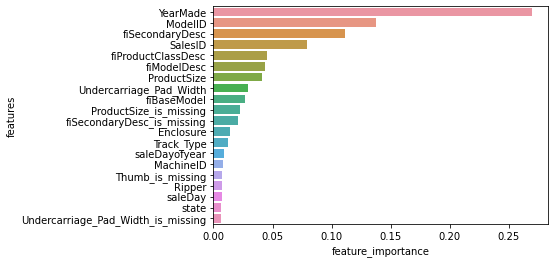

In [ ]:
plot_features(X_train.columns, ideal_model.feature_importances_)